In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vapeplot 
from scipy import interp
import scipy.stats
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

#### Goal
--------------------

The goal of this project is to make a classifier that predicts the final rankings for bakers.
The idea is to make a model for each episode and to use data from previous episodes in the model.
Therefore, a classifier for episode 1 will likely be bad at predicting the final outcome, but a classifier for episode 5 might accurately predict who will be in the top 3 and who might be eliminated in the next episode



In [2]:
from datetime import datetime
def timestamp(): return datetime.today().strftime('%Y%m%d')

from sklearn.preprocessing import QuantileTransformer
def quantile_scale(df,feats):
    qua = df
    scaler = QuantileTransformer(
        n_quantiles=10,
        random_state=42,
        ignore_implicit_zeros=True, #sparse matrix
    )
    # fit the scaler
    scaler.fit(qua[feats])
    # transform values
    qua[feats] = scaler.transform(qua[feats])
    return qua
def tiered(classes):
    trans = []
    for x in classes:
        if x==1: c=0
        if x==2: c=1
        if x>=3 and x<=4: c=2
        if x>=5 and x<=7: c=3
        if x>=8: c=4
        trans.append(c)
    return trans

In [5]:
merge_col = ['season','baker','index','episode','place']
tech = pd.read_csv("../RESULTS/gbbo.techinical.data.s10.20190914.tsv",sep="\t")
star = pd.read_csv("../RESULTS/gbbo.starbaker.data.s10.e3.20190914.tsv",sep="\t")
gbbo = pd.merge(tech, star,  how='left', left_on=merge_col, right_on =merge_col)
gbbo = gbbo[['season','baker','episode','place','tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']]
gbbo.to_csv("../RESULTS/gbbo.features.s10.e3.{}.tsv".format(timestamp()),sep="\t",index=False)
gbbo.head()

,season,baker,episode,place,tech_mean,tech,mean_star,star,mean_good,good,mean_bad,bad
0,10,Alice,1,0,5.00,5,0.00,0,0.00,0,0.00,0
1,10,Alice,2,0,3.00,1,0.50,1,0.50,1,0.00,0
2,10,Alice,3,0,4.33,7,0.33,0,0.33,0,0.33,1
3,10,Amelia,1,0,4.00,4,0.00,0,0.00,0,0.00,0
4,10,Amelia,2,0,6.50,9,0.00,0,0.00,0,0.50,1


In [6]:
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e3.20190914.tsv",sep="\t")
feats = ['tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']
max_epi = max(gbbo['episode'])
gbbo = gbbo.loc[gbbo['episode']==max_epi]
gbbo = quantile_scale(gbbo,feats)
gbbo.head()

/Users/tacitus/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2088: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"


,season,baker,episode,place,tech_mean,tech,mean_star,star,mean_good,good,mean_bad,bad
2,10,Alice,3,0,0.199601,6.666667e-01,8.888889e-01,1.000000e-07,7.777778e-01,1.000000e-07,8.333333e-01,9.999999e-01
5,10,Amelia,3,0,0.888889,9.999999e-01,8.888889e-01,9.999999e-01,1.000000e-07,1.000000e-07,8.333333e-01,1.000000e-07
8,10,Dan,3,13,0.047414,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,8.333333e-01,1.000000e-07
11,10,David,3,0,0.238506,2.500000e-01,1.000000e-07,1.000000e-07,7.777778e-01,1.000000e-07,1.000000e-07,1.000000e-07
14,10,Helena,3,0,1.000000,7.500000e-01,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07


In [7]:
tech = pd.read_csv("../RESULTS/gbbo.features.20190909.tsv",sep='\t')
tech = tech.loc[tech['episode']==max_epi]
qua = quantile_scale(tech,feats)
qua['place']=tiered(qua['place'])
X, y = np.matrix(qua[feats]), np.array(qua['place'])

/Users/tacitus/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2088: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"


In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.activations import relu
input_shape = len(feats)
output_shape = len(set(tech['place']))
def create_model( nl1=1, nl2=1,  nl3=1, 
                 nn1=1000, nn2=500, nn3 = 200, lr=0.01, decay=0., l1=0.01, l2=0.01,
                act = 'relu', dropout=0,input_shape=input_shape,output_shape=output_shape):    
    '''This is a model generating function so that we can search over neural net 
    parameters and architecture
    https://www.kaggle.com/arrogantlymodest/randomised-cv-search-over-keras-neural-network
    '''
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999,  decay=decay)
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
    model = Sequential()
    first=True  
    for i in range(nl1):
        if first:
            model.add(Dense(nn1, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn1, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))    
    for i in range(nl2):
        if first:
            model.add(Dense(nn2, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn2, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))    
    for i in range(nl3):
        if first:
            model.add(Dense(nn3, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn3, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))       
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'],)
    return model
##################################
l1 = 0.0001
l2 = 0.0001
lr = 0.0001
nl1 = 1
nl2 = 1
nl3 = 1
nn1 = 800
nn2 = 800
nn3 = 300

dropout = 0.1
decay = 1e-09
act='relu'
n_dims = len(feats)
n_classes = len(set(tech['place']))

nn = create_model( nl1=nl1, nl2=nl2,  nl3=nl3, 
                     nn1=nn1, nn2=nn2, nn3 = nn3, 
                     lr=lr, decay=decay, l1=l1, l2=l2,
                     act = act, dropout=dropout,
                     input_shape=n_dims,
                     output_shape=n_classes)

BATCH,EPOCHS = 12, 25
####
X, y = np.matrix(qua[feats]), np.array(qua['place'])
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e3.20190914.tsv",sep="\t")
feats = ['tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']
max_epi = max(gbbo['episode'])
gbbo = gbbo.loc[gbbo['episode']==max_epi]
gbbo = quantile_scale(gbbo,feats)
test = np.matrix(gbbo[feats])

tech = pd.read_csv("../RESULTS/gbbo.features.20190909.tsv",sep='\t')
tech = tech.loc[tech['episode']==max_epi]
qua = quantile_scale(tech,feats)
qua['place']=tiered(qua['place'])
nn.fit(X,y,validation_split=0., batch_size=BATCH, epochs=EPOCHS,verbose=0)

preds = nn.predict_classes(test)
probs = nn.predict_proba(test)
gbbo['preds']=preds
# probability baker is a finalist
top = probs[:,0]
# probability baker is a finalist or a runner-up
top3 = probs[:,0]+probs[:,1]
# bottom tier (8th and below)
bot = probs[:,-1]
gbbo['bottom']=np.round(bot*100,decimals=2)
gbbo['finalist']=np.round(top*100,decimals=2) 
gbbo['top3'] = np.round(top3*100,decimals=2)
gbbo.to_csv("../RESULTS/gbbo.techinical.s10.e3.keras.preditions.txt",sep="\t",index=False)
sub = ['baker','preds','finalist','top3','bottom']
gbbo = gbbo[sub].sort_values(by=['finalist'],ascending=False)
print(gbbo)

       baker  preds   finalist       top3     bottom
11     David      1  18.740000  47.810001  13.300000
38     Steph      1  17.200001  58.910000   7.000000
35     Rosie      1  15.990000  43.990002  11.270000
23   Michael      1  13.830000  67.180000   2.430000
2      Alice      3  13.070000  29.610001  19.830000
32     Priya      3   9.090000  24.930000  22.530001
26  Michelle      3   8.430000  24.100000  21.320000
29      Phil      3   6.180000  20.490000  15.120000
14    Helena      3   5.530000  19.809999  21.850000
17     Henry      4   4.240000   9.030000  35.980000
5     Amelia      4   3.970000  15.240000  43.070000
8        Dan      4   3.450000   7.000000  75.129997
20     Jamie      4   0.700000   1.620000  93.029999


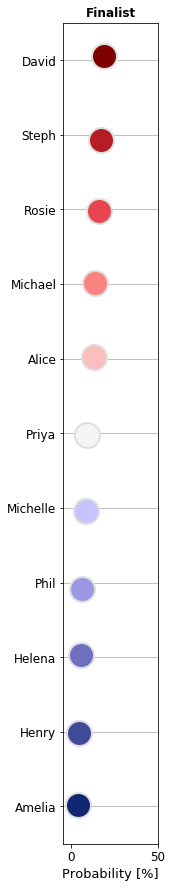

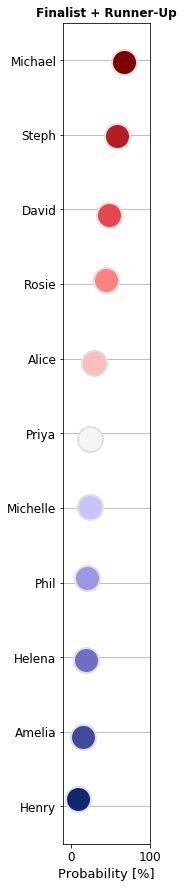

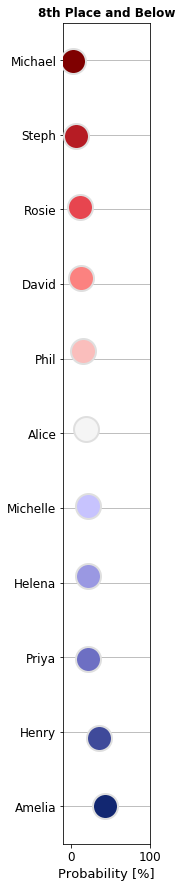

In [14]:
def plot_probs(df,x,xlab,ofh,xmin=-9,xmax=100):
    #col=['#012169', '#3d4081', '#64629a', '#8b87b2', '#b1adcc', '#d7d5e5', '#ffffff', '#fddcd9', '#f8b9b4', '#f09790', '#e5736d', '#d84c4d', '#c8102e']
    col=['#122771', '#3f4a9a', '#6d6fc3', '#9a98e2', '#c7c3fe', '#f5f5f5', '#fabebc', '#fb8280', '#e7454f', '#b61c24', '#7f0000']
    colrs=reversed(col)

    vapeplot.font_size(12)
    f, ax = plt.subplots(1,1,figsize=(2.5,5*2.5))
    sns.stripplot(
        y='baker',
        x=x,
        data=df,
        linewidth=2, 
        edgecolor="#dfdfdf",
        size=25,
        ax=ax,
        palette=colrs
    )
    ax.set_ylabel('')
    ax.yaxis.grid(True)
    ax.set_xlim(xmin,xmax)
    ax.set_title(xlab,fontsize=12,weight='bold')
    ax.set_xlabel('Probability [%]',fontsize=13)
    f.tight_layout()
    f.savefig(ofh,dpi=150)
    f.show()

lost = ['Dan','Jamie']
gbbo = gbbo.loc[~gbbo['baker'].isin(lost)]
plot_probs(gbbo,'finalist','Finalist','../FIGURES/s10.e3.finalist.png',-4.5,50)   
plot_probs(gbbo.sort_values(ascending=False,by=['top3']),'top3','Finalist + Runner-Up','../FIGURES/s10.e3.top3.png')
plot_probs(gbbo.sort_values(ascending=True,by=['bottom']),'bottom','8th Place and Below','../FIGURES/s10.e3.bottom.png')

In [9]:
gbbo[sub].sort_values(by=['bottom'],ascending=False)

,baker,preds,finalist,top3,bottom
5,Dan,4,2.110000,5.870000,82.529999
13,Jamie,4,0.300000,1.730000,77.889999
3,Amelia,4,0.990000,4.320000,60.250000
21,Priya,3,3.550000,13.640000,30.740000
9,Helena,3,1.480000,8.320000,30.370001
17,Michelle,3,3.250000,13.050000,28.240000
19,Phil,4,7.450000,21.250000,28.030001
11,Henry,3,7.670000,22.250000,16.889999
15,Michael,1,23.150000,61.009998,13.470000
7,David,1,19.510000,63.900002,12.080000


In [10]:
gbbo[sub].sort_values(by=['top3'],ascending=False)


,baker,preds,finalist,top3,bottom
1,Alice,1,35.049999,86.050003,1.960000
7,David,1,19.510000,63.900002,12.080000
15,Michael,1,23.150000,61.009998,13.470000
23,Rosie,2,22.150000,48.790001,6.350000
25,Steph,2,11.720000,32.580002,7.530000
11,Henry,3,7.670000,22.250000,16.889999
19,Phil,4,7.450000,21.250000,28.030001
21,Priya,3,3.550000,13.640000,30.740000
17,Michelle,3,3.250000,13.050000,28.240000
9,Helena,3,1.480000,8.320000,30.370001


/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2142: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"
/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2142: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab

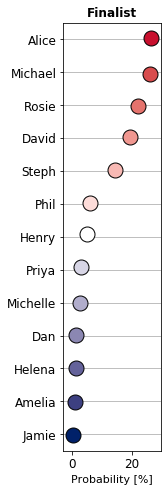

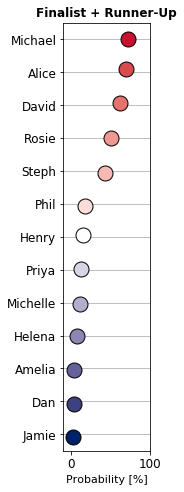

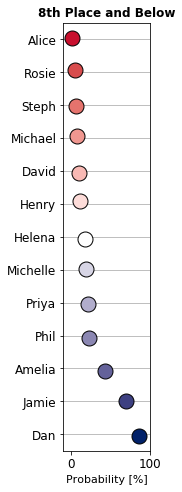

In [108]:
tech = pd.read_csv("../RESULTS/gbbo.features.20190909.tsv",sep='\t')
tech = tech.loc[(tech['episode']==2) | (tech['episode']==3)]
qua = quantile_scale(tech,feats)
qua['place']=tiered(qua['place'])
X, y = np.matrix(qua[feats]), np.array(qua['place'])
nn = create_model( nl1=nl1, nl2=nl2,  nl3=nl3, 
                     nn1=nn1, nn2=nn2, nn3 = nn3, 
                     lr=lr, decay=decay, l1=l1, l2=l2,
                     act = act, dropout=dropout,
                     input_shape=n_dims,
                     output_shape=n_classes)
nn.fit(X,y,validation_split=0., batch_size=BATCH, epochs=EPOCHS,verbose=0)
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e2.20190909.tsv".format(),sep="\t")
feats = ['tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']
max_epi = max(gbbo['episode'])
gbbo = gbbo.loc[gbbo['episode']==max_epi]
gbbo = quantile_scale(gbbo,feats)
test = np.matrix(gbbo[feats])
preds = nn.predict_classes(test)
probs = nn.predict_proba(test)
gbbo['preds']=preds
# probability baker is a finalist
top = probs[:,0]
top3 = probs[:,0]+probs[:,1]
bot = probs[:,-1]
gbbo['bottom']=np.round(bot*100,decimals=2)
gbbo['finalist']=np.round(top*100,decimals=2) 
gbbo['top3'] = np.round(top3*100,decimals=2)
#gbbo.to_csv("../RESULTS/gbbo.techinical.s10.e2.keras.preditions.txt",sep="\t",index=False)
sub = ['baker','preds','finalist','top3','bottom']
gbbo = gbbo[sub].sort_values(by=['finalist'],ascending=False)

plot_probs(gbbo,'finalist','Finalist','../FIGURES/s10.e2-3.finalist.png',-3,30)   
plot_probs(gbbo.sort_values(ascending=False,by=['top3']),'top3','Finalist + Runner-Up','../FIGURES/s10.e2-3.top3.png')
plot_probs(gbbo.sort_values(ascending=True,by=['bottom']),'bottom','8th Place and Below','../FIGURES/s10.e2-3.bottom.png')



In [15]:
gbbo[sub].sort_values(by=['bottom'],ascending=False)

,baker,preds,finalist,top3,bottom
5,Dan,4,1.220000,3.610000,86.370003
13,Jamie,4,0.330000,2.210000,74.680000
3,Amelia,4,1.050000,4.200000,48.380001
21,Priya,3,3.160000,13.840000,28.010000
19,Phil,3,6.140000,18.879999,27.490000
9,Helena,3,1.450000,9.640000,24.260000
17,Michelle,3,2.910000,13.020000,23.950001
11,Henry,3,5.930000,16.480000,13.520000
7,David,1,20.879999,65.339996,10.700000
15,Michael,1,26.020000,77.470001,7.590000
